In [38]:
import json
import urllib.request as ur

from tqdm.notebook import tqdm as tq

import xarray as xr
import numpy as np
import pandas as pd

import corner

from scipy.optimize import curve_fit
import lmfit

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

_np = np.seterr(all="ignore", divide="raise")

In [4]:
url = 'https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-COUNTRIES.json'
with ur.urlopen(url) as _url:
    _data = json.loads(_url.read().decode())

In [5]:
# create empty 3d array

F = ["Logit", "DobLogit", "Gomp", "DobGomp"]
D = pd.to_datetime(list(_data["Italy"]["Confirmed"].keys()))

null_dict = {
    "date": [pd.Timestamp(d) for d in D],
    "measured": [None for _ in range(len(D))],
    "Logit": [None for _ in range(len(D))],
    "DobLogit": [None for _ in range(len(D))],
    "Gomp": [None for _ in range(len(D))],
    "DobGomp": [None for _ in range(len(D))],
}

_a = null_dict

In [6]:
# load measured data in array x

for _d, d in enumerate(_data["Italy"]["Confirmed"]):
    _a["measured"][_d] = _data["Italy"]["Confirmed"][d]

In [75]:
# interpolate on functions

for _f, function in enumerate([logit, doblogit, gomp, dobgomp]):
    try:
        interp = function(list(_data["Italy"]["Confirmed"].values()))
        _a[F[_f]] = interp
    except Exception as err:
        print(f"{function} -> {err}")

In [76]:
A = pd.DataFrame(_a, columns=list(_a.keys()))

In [77]:
A.set_index("date", inplace=True)

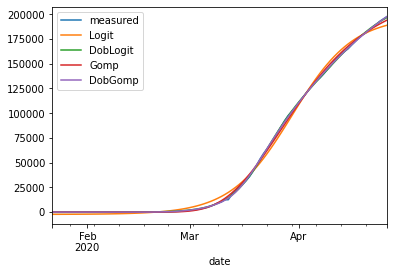

In [78]:
A.plot()

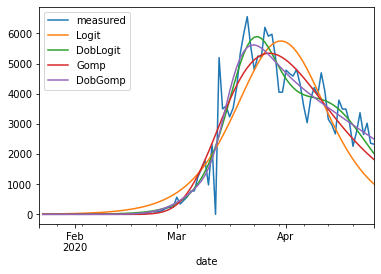

In [79]:
A.diff().plot()

In [7]:
def gompertz_residuals(pars, x, data=None):
    vals = pars.valuesdict()
    a = vals["a"]
    b = vals["b"]
    k = vals["k"]
    e = vals["e"]

    exp = - np.exp(k * (b - x))
    model = a * np.exp(exp) + e
    
    if data is None:
        return model
    return model - data


def lmfit_gompertz(cases):
    new_cases = pd.Series(cases).diff()
    max_new_cases = new_cases.argmax()
    
    x = [i for i in range(len(cases))]
    
    p0 = Parameters()
    p0.add('a', value=cases[-1])
    p0.add('b', value=max_new_cases)
    p0.add('k', value=1)
    p0.add('e', value=cases[0])
    
    out = minimize(gompertz_residuals, p0, args=(x,), kws={'data': cases})

    return out

In [8]:
def logit_residuals(pars, x, data=None):
    vals = pars.valuesdict()
    a = vals["a"]
    b = vals["b"]
    k = vals["k"]
    e = vals["e"]

    d = k * (b - np.array(x))
    model = (a / (1 + np.exp(d))) + e
    
    if data is None:
        return model
    return model - data


def lmfit_logit(cases):
    new_cases = pd.Series(cases).diff()
    max_new_cases = new_cases.argmax()
    
    x = [i for i in range(len(cases))]
    
    p0 = Parameters()
    p0.add('a', value=cases[-1])
    p0.add('b', value=max_new_cases)
    p0.add('k', value=1)
    p0.add('e', value=cases[0])
    
    out = minimize(logit_residuals, p0, args=(x,), kws={'data': cases})

    return out

In [9]:
out_gomp = lmfit_gompertz(
    list(_data["Italy"]["Confirmed"].values())
)

In [10]:
out_gomp

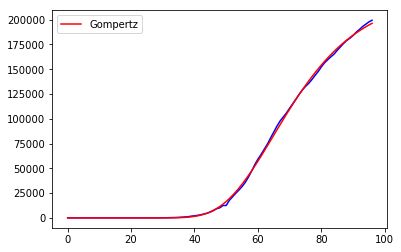

In [11]:
y = list(_data["Italy"]["Confirmed"].values())
x = [i for i in range(len(y))]

plt.plot(x, y, 'b')
plt.plot(x, gompertz_residuals(out_gomp.params, x), 'r', label='Gompertz')
plt.legend(loc='best')
plt.show()

In [12]:
out_logit = lmfit_logit(
    list(_data["Italy"]["Confirmed"].values())
)

In [13]:
out_logit

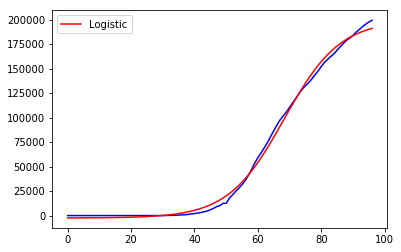

In [14]:
y = list(_data["Italy"]["Confirmed"].values())
x = [i for i in range(len(y))]

plt.plot(x, y, 'b')
plt.plot(x, logit_residuals(out_logit.params, x), 'r', label='Logistic')
plt.legend(loc='best')
plt.show()

In [15]:
def double_gompertz_residuals(pars, x, data=None):
    vals = pars.valuesdict()
    a1 = vals["a1"]
    b1 = vals["b1"]
    k1 = vals["k1"]
    a2 = vals["a2"]
    b2 = vals["b2"]
    k2 = vals["k2"]
    e = vals["e"]

    exp1 = - np.exp(k1 * (b1 - x))
    g1 = a1 * np.exp(exp1)
    exp2 = - np.exp(k2 * (b2 - x))
    g2 = (a2 - a1) * np.exp(exp2)
    model = g1 + g2 + e
    
    if data is None:
        return model
    return model - data


def lmfit_double_gompertz(cases):
    new_cases = pd.Series(cases).diff()
    max_new_cases = new_cases.argmax()
    
    x = [i for i in range(len(cases))]
    
    p0 = Parameters()
    p0.add('a1', value=(cases[max_new_cases] * 2))
    p0.add('b1', value=max_new_cases)
    p0.add('k1', value=1)
    p0.add('a2', value=(max(cases) * 2))
    p0.add('b2', value=len(cases))
    p0.add('k2', value=1)
    p0.add('e', value=cases[0])
    
    out = minimize(double_gompertz_residuals, p0, args=(x,), kws={'data': cases})

    return out

In [16]:
out_double_gompertz = lmfit_double_gompertz(
    list(_data["Italy"]["Confirmed"].values())
)

In [17]:
out_double_gompertz

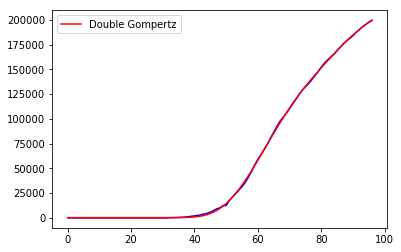

In [18]:
y = list(_data["Italy"]["Confirmed"].values())
x = [i for i in range(len(y))]

plt.plot(x, y, 'b')
plt.plot(x, double_gompertz_residuals(out_double_gompertz.params, x), 'r', label='Double Gompertz')
plt.legend(loc='best')
plt.show()

In [19]:
def double_logit_residuals(pars, x, data=None):
    vals = pars.valuesdict()
    a1 = vals["a1"]
    b1 = vals["b1"]
    k1 = vals["k1"]
    a2 = vals["a2"]
    b2 = vals["b2"]
    k2 = vals["k2"]
    e = vals["e"]

    d1 = k1 * (b1 - np.array(x))
    l1 = a1 / (1 + np.exp(d1))
    d2 = k2 * (b2 - np.array(x))
    l2 = (a2 - a1) / (1 + np.exp(d2))
    model = l1 + l2 + e
    
    if data is None:
        return model
    return model - data


def lmfit_double_logit(cases):
    new_cases = pd.Series(cases).diff()
    max_new_cases = new_cases.argmax()
    
    x = [i for i in range(len(cases))]
    
    p0 = Parameters()
    p0.add('a1', value=(cases[max_new_cases] * 2))
    p0.add('b1', value=max_new_cases)
    p0.add('k1', value=1)
    p0.add('a2', value=max(cases))
    p0.add('b2', value=len(cases))
    p0.add('k2', value=1)
    p0.add('e', value=cases[0])
    
    out = minimize(double_logit_residuals, p0, args=(x,), kws={'data': cases})

    return out

In [20]:
out_double_logit = lmfit_double_logit(
    list(_data["Italy"]["Confirmed"].values())
)

In [21]:
out_double_logit

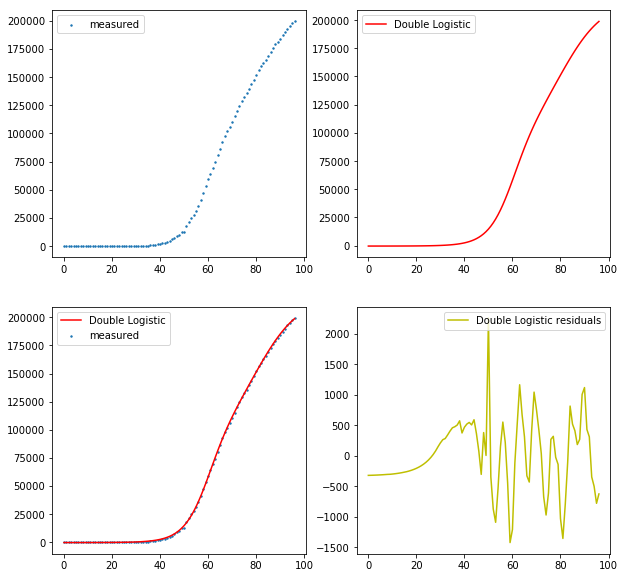

In [45]:
y = np.array(list(_data["Italy"]["Confirmed"].values()))
x = pd.to_datetime(list(_data["Italy"]["Confirmed"].keys()))
_x = np.arange(0, len(x))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axs.flat[0].scatter(_x, y, label="measured", s=2)
axs.flat[0].legend(loc='best')

y_hat = double_logit_residuals(out_double_logit.params, _x)
axs.flat[1].plot(_x, y_hat, label="Double Logistic", c="r")
axs.flat[1].legend(loc='best')

axs.flat[2].scatter(_x, y, label="measured", s=2)
axs.flat[2].plot(_x, y_hat, label="Double Logistic", c="r")
axs.flat[2].legend(loc='best')

axs.flat[3].plot(_x, double_logit_residuals(out_double_logit.params, _x, data=y), 'y', label='Double Logistic residuals')
axs.flat[3].legend(loc='best')

plt.show()

In [46]:
residual = double_logit_residuals(out_double_logit.params, _x, data=y)

In [62]:
cases = list(_data["Italy"]["Confirmed"].values())

new_cases = pd.Series(cases).diff()
max_new_cases = new_cases.argmax()
p = Parameters()
p.add('a1', value=(cases[max_new_cases] * 2))
p.add('b1', value=max_new_cases)
p.add('k1', value=1)
p.add('a2', value=max(cases))
p.add('b2', value=len(cases))
p.add('k2', value=1)
p.add('e', value=cases[0])

def double_logit_residuals(p):

def check_params():
    
    y = np.array(list(_data["Italy"]["Confirmed"].values()))
    _x = pd.to_datetime(list(_data["Italy"]["Confirmed"].keys()))
    x = np.arange(0, len(_x))

    mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')
    
    lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
    
    plt.plot(x, y, 'b')
    plt.plot(x, residual(mi.params) + y, 'r', label='best fit')
    plt.legend(loc='best')
    plt.show()
    
    mi.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

    res = lmfit.minimize(
        double_logit_residuals(out_double_logit.params, x, data=y), 
        mi.params, 
        method='emcee', nan_policy='omit', burn=300, steps=1000, thin=20,
        is_weighted=False, progress=False)

    plt.plot(res.acceptance_fraction)
    plt.xlabel('walker')
    plt.ylabel('acceptance fraction')
    plt.show()

    emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                               truths=list(res.params.valuesdict().values()))

[[Variables]]
    a1:  107156.000 (init = 107156)
    b1:  59.0000000 (init = 59)
    k1:  1.00000000 (init = 1)
    a2:  199414.000 (init = 199414)
    b2:  97.0000000 (init = 97)
    k2:  1.00000000 (init = 1)
    e:   0.00000000 (init = 0)


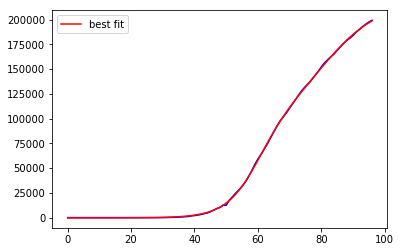

TypeError: 'numpy.ndarray' object is not callable

In [63]:
check_params()

In [116]:
import emcee


In [117]:
emcee.__file__

'/Users/massimopierini/opt/anaconda3/envs/covid/lib/python3.7/site-packages/emcee/__init__.py'